# ---------------------- Imports ----------------------

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score

# ---------------------- Dataset Class ----------------------

In [3]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Notice the change: now both image and mask are 'L' mode (grayscale)
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# ---------------------- Paths & Setup ----------------------

In [4]:
image_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Actual scenario IR data/IR new video extracted frames/images",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Actual scenario IR data/ir_video_data_yolo/images",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Bridge data/images",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/images/train",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/images/val",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/images/test",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/norm_ir_8bit",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/IR_norm8bit"
]

mask_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Actual scenario IR data/IR new video extracted frames/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Actual scenario IR data/ir_video_data_yolo/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/Bridge data/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/saliency_masks/train",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/saliency_masks/val",
    r"/home/user/Shivam/dsr_project/dataset/IR-data/hit-uav/saliency_masks/test",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/Saliency_map/IR"
]

# Collect all images and masks
image_files = []
mask_files = []

for img_dir, msk_dir in zip(image_dirs, mask_dirs):
    imgs = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")])
    msks = sorted([os.path.join(msk_dir, f) for f in os.listdir(msk_dir) if f.endswith(".jpg") or f.endswith(".png")])

    assert len(imgs) == len(msks), f"Mismatch in number of images and masks in {img_dir}"

    image_files.extend(imgs)
    mask_files.extend(msks)

# Split into training and test sets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# ---------------------- Transforms ----------------------

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# ---------------- Datasets and DataLoaders ----------------

In [6]:
train_dataset = SaliencyDataset(train_imgs, train_masks, transform=transform)
test_dataset = SaliencyDataset(test_imgs, test_masks, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------- Verify dataset ----------------------

Total images: 31566
Total masks: 31566
Training images: 25252, Training masks: 25252
Testing images: 6314, Testing masks: 6314


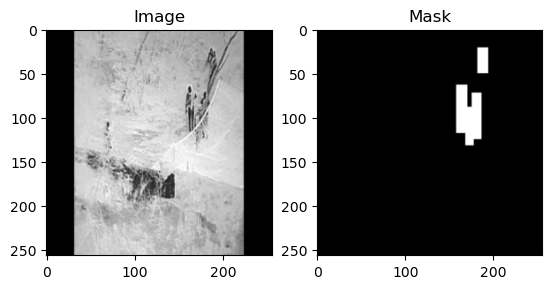

In [7]:
print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")
print(f"Training images: {len(train_imgs)}, Training masks: {len(train_masks)}")
print(f"Testing images: {len(test_imgs)}, Testing masks: {len(test_masks)}")
# Visualize some train images and masks
img, msk = train_dataset[100]
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(msk.squeeze(), cmap='gray')
plt.title('Mask')
plt.show()

# ---------------------- Defined Model ----------------------

In [2]:
class Saliency_IR(nn.Module):   
    def __init__(self):
        super(Saliency_IR, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ---------------------- Training Setup ----------------------

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------

In [10]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.1193
Epoch [2/100], Loss: 0.0909
Epoch [3/100], Loss: 0.0821
Epoch [4/100], Loss: 0.0747
Epoch [5/100], Loss: 0.0682
Epoch [6/100], Loss: 0.0634
Epoch [7/100], Loss: 0.0604
Epoch [8/100], Loss: 0.0579
Epoch [9/100], Loss: 0.0554
Epoch [10/100], Loss: 0.0537
Epoch [11/100], Loss: 0.0520
Epoch [12/100], Loss: 0.0507
Epoch [13/100], Loss: 0.0492
Epoch [14/100], Loss: 0.0481
Epoch [15/100], Loss: 0.0473
Epoch [16/100], Loss: 0.0467
Epoch [17/100], Loss: 0.0456
Epoch [18/100], Loss: 0.0454
Epoch [19/100], Loss: 0.0446
Epoch [20/100], Loss: 0.0440
Epoch [21/100], Loss: 0.0437
Epoch [22/100], Loss: 0.0430
Epoch [23/100], Loss: 0.0425
Epoch [24/100], Loss: 0.0420
Epoch [25/100], Loss: 0.0419
Epoch [26/100], Loss: 0.0417
Epoch [27/100], Loss: 0.0409
Epoch [28/100], Loss: 0.0408
Epoch [29/100], Loss: 0.0407
Epoch [30/100], Loss: 0.0401
Epoch [31/100], Loss: 0.0399
Epoch [32/100], Loss: 0.0400
Epoch [33/100], Loss: 0.0397
Epoch [34/100], Loss: 0.0396
Epoch [35/100], Loss: 0

# ---------------------- Visualization ----------------------

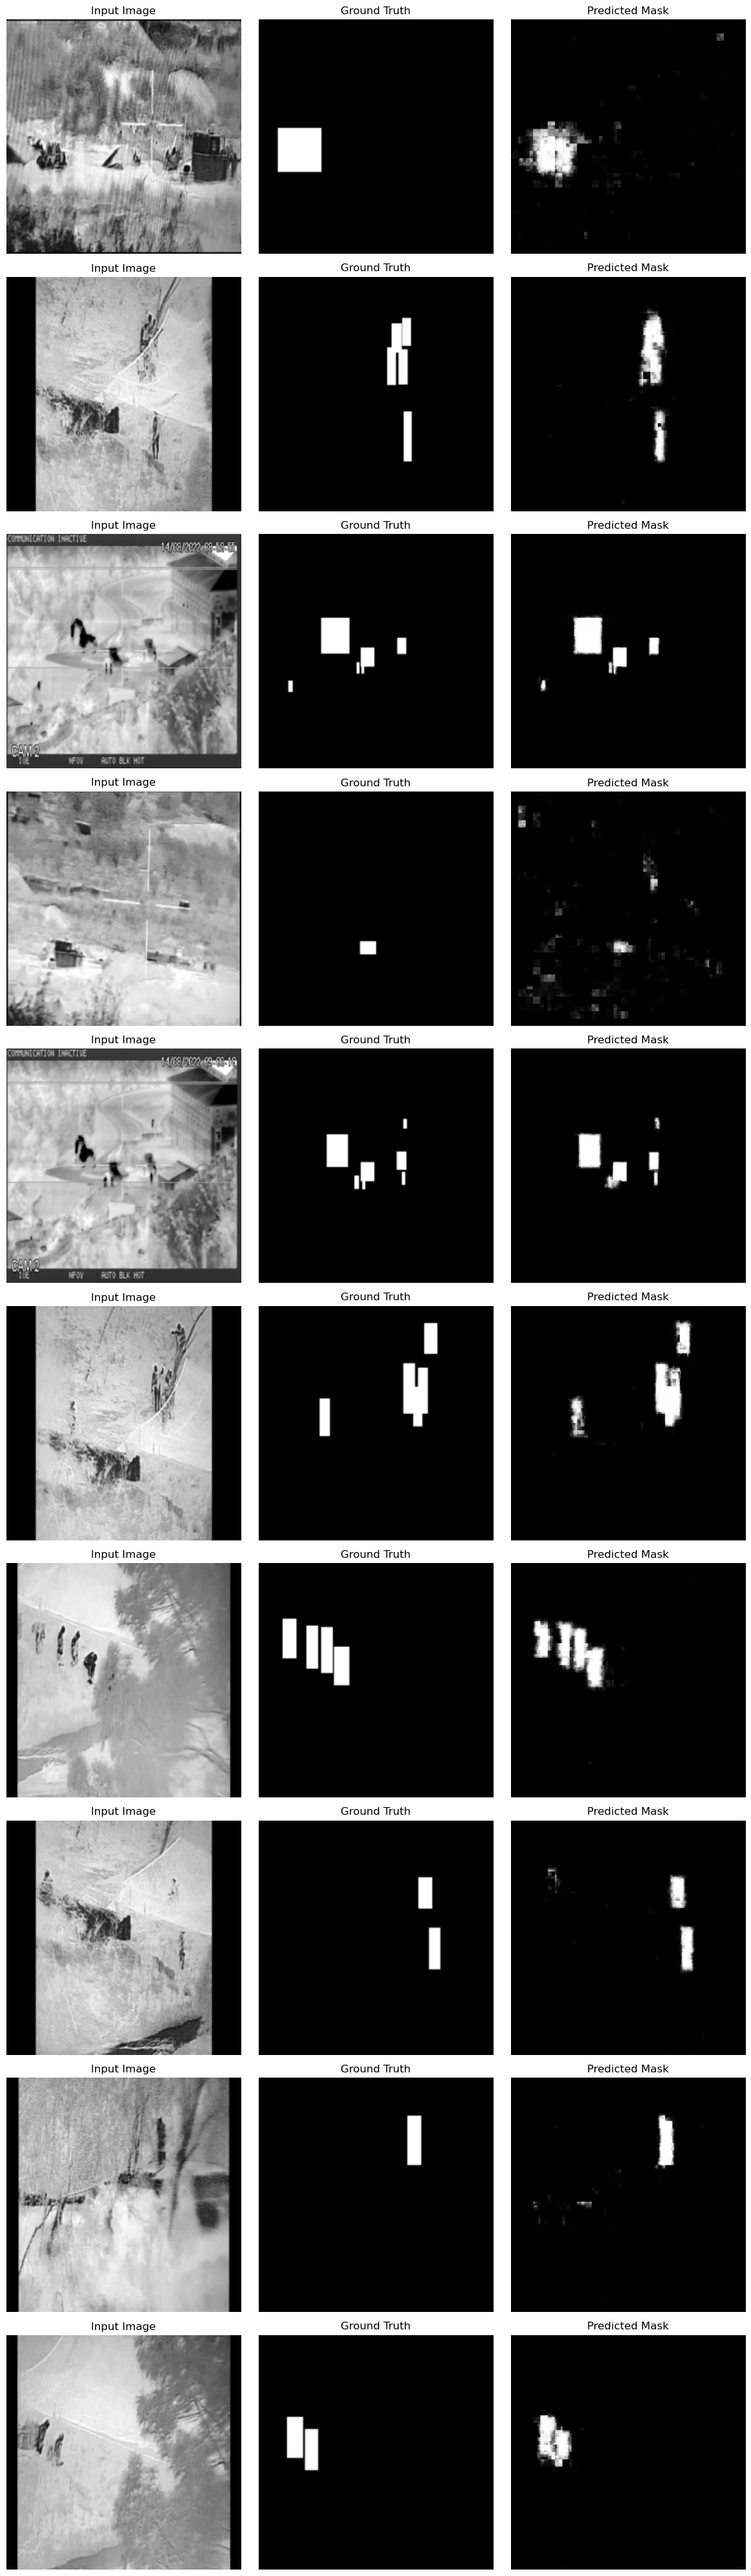

In [11]:
model.eval()
with torch.no_grad():
    random_indices = random.sample(range(len(test_dataset)), 10)

    fig, axes = plt.subplots(10, 3, figsize=(12, 40))

    for idx, random_idx in enumerate(random_indices):
        image, mask = test_dataset[random_idx]
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        mask = mask.unsqueeze(0).to(device)

        output = model(image)

        # Prepare for plotting
        image_np = image.squeeze(0).squeeze(0).cpu().numpy()
        mask_np = mask.squeeze(0).squeeze(0).cpu().numpy()
        output_np = output.squeeze(0).squeeze(0).cpu().numpy()

        axes[idx, 0].imshow(image_np, cmap='gray')
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(output_np, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------- Saving the model -------------------

In [12]:
torch.save(model.state_dict(), "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.pth")
print("Model saved as saliency_model_ir.pth")

Model saved as saliency_model_ir.pth


In [ ]:
# Instantiate model and load weights
model = Saliency_IR().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.pth"))
model.eval()

In [14]:
# ---------------------- Model Summary ---------------------
summary(model, input_size=(1, 256, 256))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
              ReLU-5        [-1, 128, 128, 128]               0
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
              ReLU-8          [-1, 256, 64, 64]               0
         MaxPool2d-9          [-1, 256, 32, 32]               0
  ConvTranspose2d-10          [-1, 128, 64, 64]         131,200
             ReLU-11          [-1, 128, 64, 64]               0
  ConvTranspose2d-12         [-1, 64, 128, 128]          32,832
             ReLU-13         [-1, 64, 128, 128]               0
  ConvTranspose2d-14          [-1, 1, 2

# ------------------ Export Model to ONNX ------------------

In [15]:
dummy_input = torch.randn(1, 1, 256, 256).to(device)  # Example input size

onnx_export_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.onnx"

torch.onnx.export(
    model, dummy_input, onnx_export_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True
)

print(f"Model exported successfully to {onnx_export_path}")

Model exported successfully to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.onnx


# ------------------- Verify ONNX Model -------------------

In [16]:
# Load ONNX model
onnx_model = onnx.load(onnx_export_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

# Set up inference session
ort_session = ort.InferenceSession(onnx_export_path)

# Test inference on random input
dummy_input_numpy = np.random.randn(1, 1, 256, 256).astype(np.float32)

# Inference
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input_numpy}
ort_outs = ort_session.run(None, ort_inputs)

print(f"ONNX Inference output shape: {ort_outs[0].shape}")

ONNX model is valid!
ONNX Inference output shape: (1, 1, 256, 256)


# ------------ Metrics and application example ------------

In [17]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    true_bin = (true_mask > 0.5).astype(np.uint8)

    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()

    if union == 0:  # Avoid division by zero
        return float(intersection == 0)
    return intersection / union

ious = []

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()
            iou = compute_iou(pred, true)
            ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU on test set: {mean_iou:.4f}")

Mean IoU on test set: 0.6690


In [18]:
def compute_min_salient_fraction(dataloader):
    min_fraction = float('inf')
    valid_count = 0

    for _, masks in dataloader:
        for mask in masks:
            mask_np = mask[0].numpy()
            binary_mask = (mask_np > 0.5).astype(np.uint8)
            total_pixels = binary_mask.size
            salient_pixels = np.sum(binary_mask)

            if salient_pixels == 0:
                continue  # Skip completely black masks

            frac = salient_pixels / total_pixels
            min_fraction = min(min_fraction, frac)
            valid_count += 1

    if valid_count == 0:
        raise ValueError("No non-empty masks found in dataset.")

    return min_fraction

threshold_fraction = compute_min_salient_fraction(test_loader)
print(f"Data-driven Saliency Threshold (non-empty GT): {threshold_fraction:.4f}")

Data-driven Saliency Threshold (non-empty GT): 0.0004


In [19]:
def is_object_present(saliency_map, threshold=0.5, pixel_fraction=0.001):
    binary_mask = saliency_map > threshold
    active_pixels = np.sum(binary_mask)
    total_pixels = binary_mask.size
    return active_pixels / total_pixels > pixel_fraction

In [20]:
# Object detection recall based on saliency
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()

            # GT: is there any object in the mask?
            object_in_gt = is_object_present(true, threshold=0.5, pixel_fraction=0.001)
            object_in_pred = is_object_present(pred, threshold=0.5, pixel_fraction=0.001)

            y_true.append(object_in_gt)
            y_pred.append(object_in_pred)

# Compute Recall
true_positive = sum([t and p for t, p in zip(y_true, y_pred)])
false_negative = sum([t and not p for t, p in zip(y_true, y_pred)])
recall = true_positive / (true_positive + false_negative + 1e-6)  # avoid division by zero
print(f"Object Presence Recall: {recall:.4f}")


Object Presence Recall: 0.9859


In [21]:
y_true, y_pred = [], []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        pred = outputs[0][0].cpu().numpy()
        true = masks[0][0].cpu().numpy()

        pred_bin = (pred > 0.5).astype(np.uint8)
        true_bin = (true > 0.5).astype(np.uint8)

        pred_fraction = np.sum(pred_bin) / pred_bin.size
        true_fraction = np.sum(true_bin) / true_bin.size

        object_pred = pred_fraction > threshold_fraction
        object_true = true_fraction > threshold_fraction

        y_true.append(object_true)
        y_pred.append(object_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9865
Recall:    0.9905
F1-score:  0.9885


Predicted: Object Present
Ground Truth: Object Present


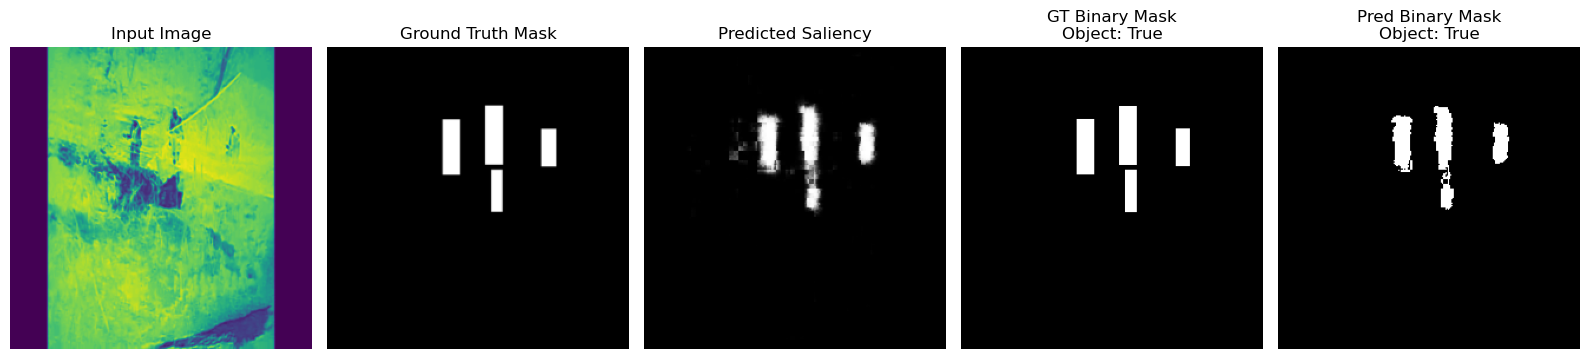

Predicted: Object Present
Ground Truth: Object Present


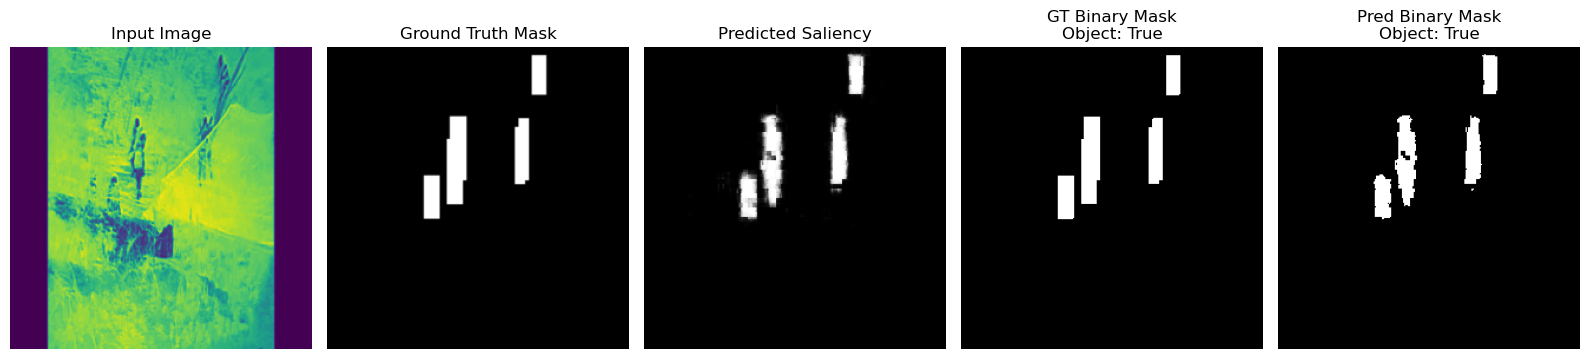

Predicted: Object Present
Ground Truth: Object Present


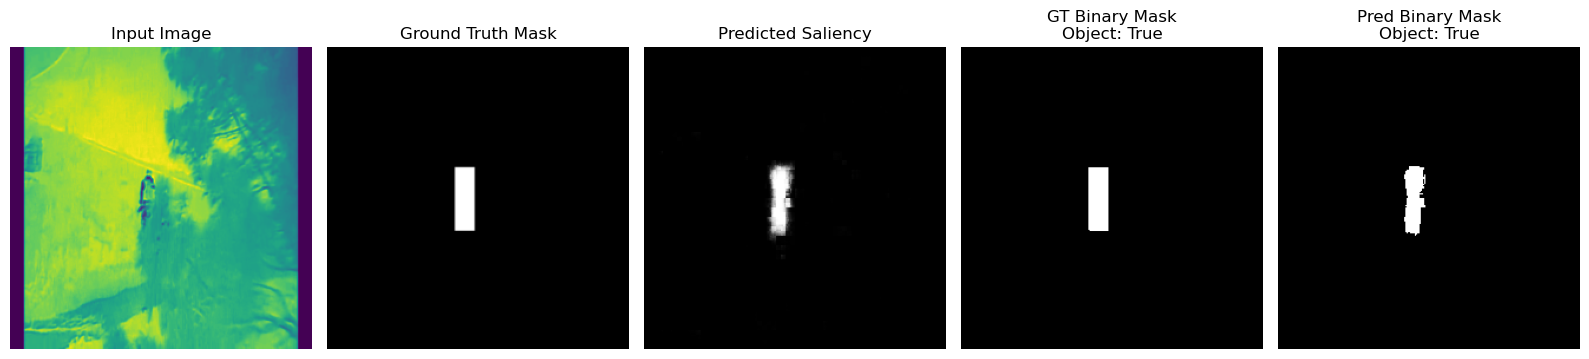

Predicted: Object Present
Ground Truth: Object Present


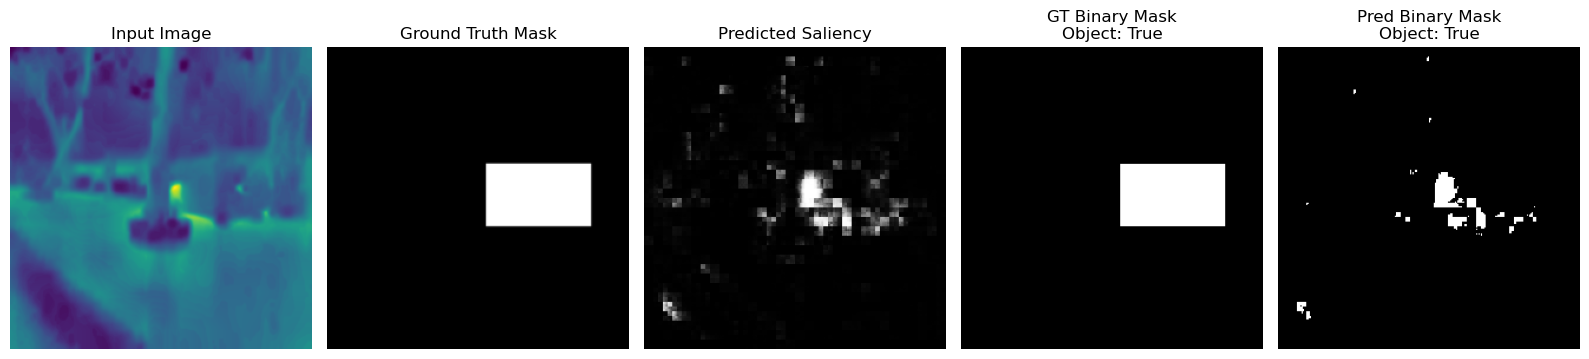

Predicted: Object Present
Ground Truth: Object Present


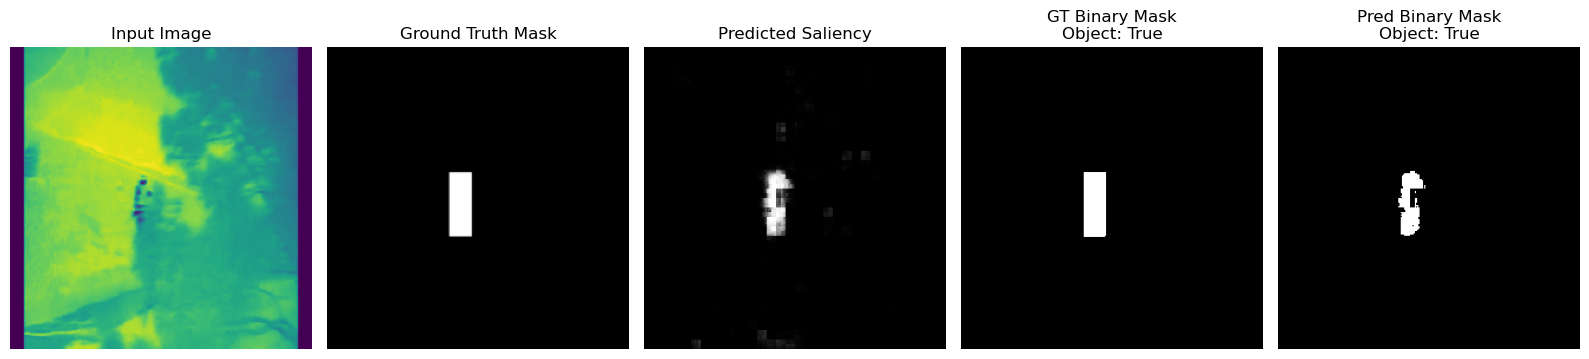

Predicted: No Object
Ground Truth: Object Present


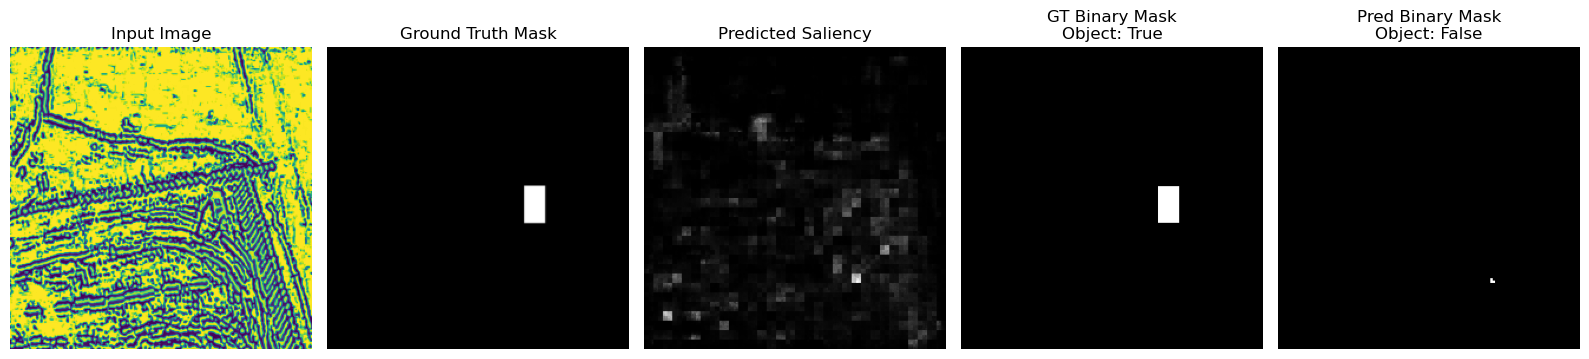

Predicted: Object Present
Ground Truth: Object Present


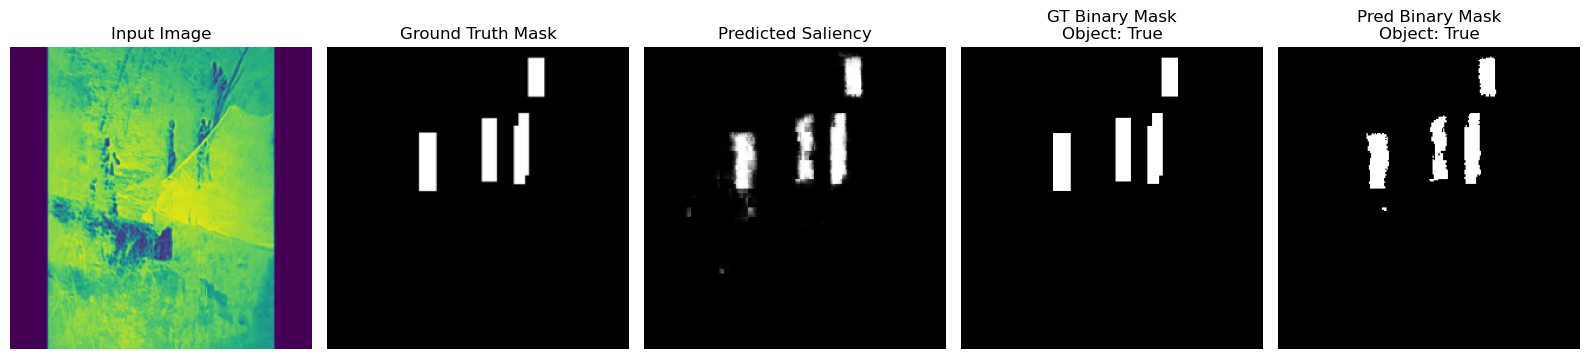

Predicted: Object Present
Ground Truth: Object Present


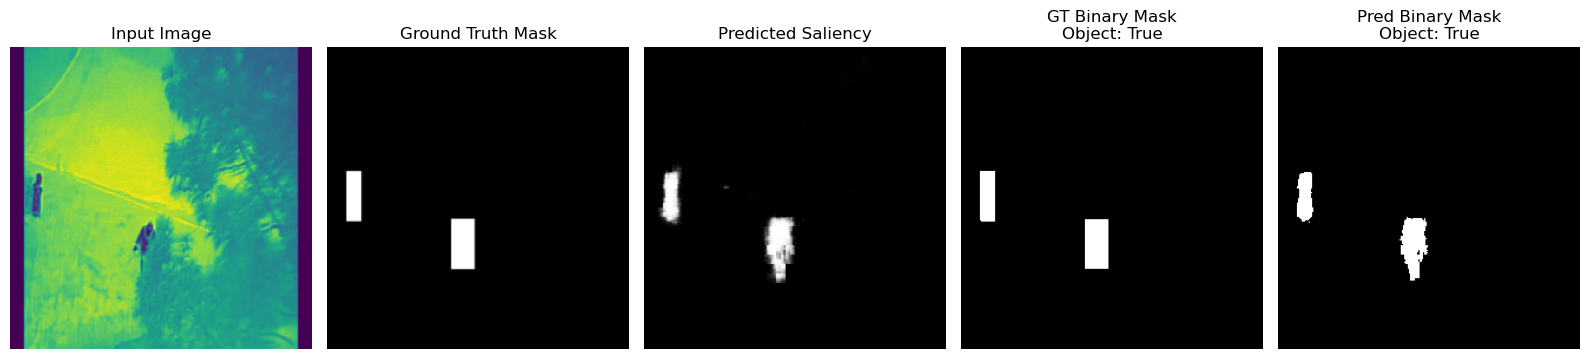

Predicted: Object Present
Ground Truth: Object Present


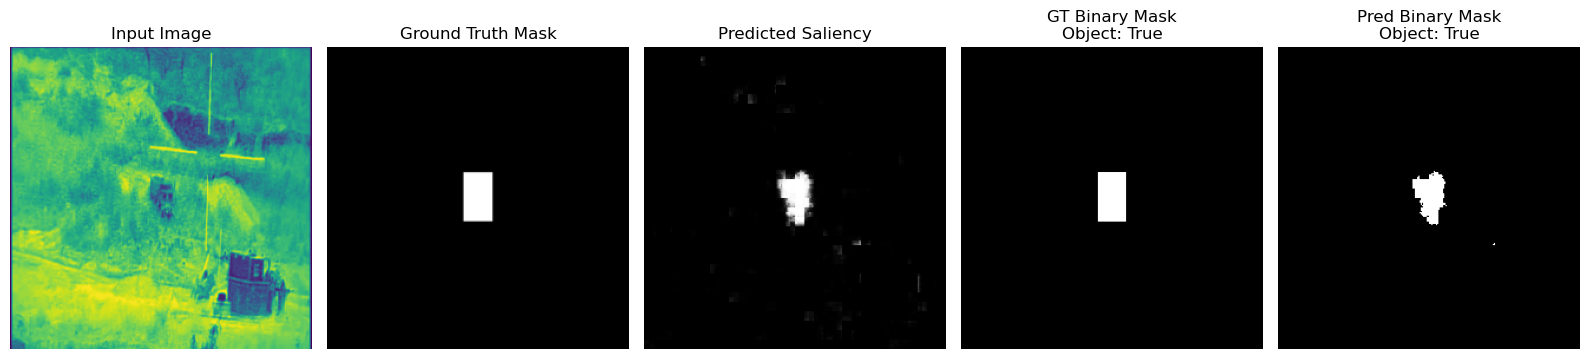

Predicted: Object Present
Ground Truth: Object Present


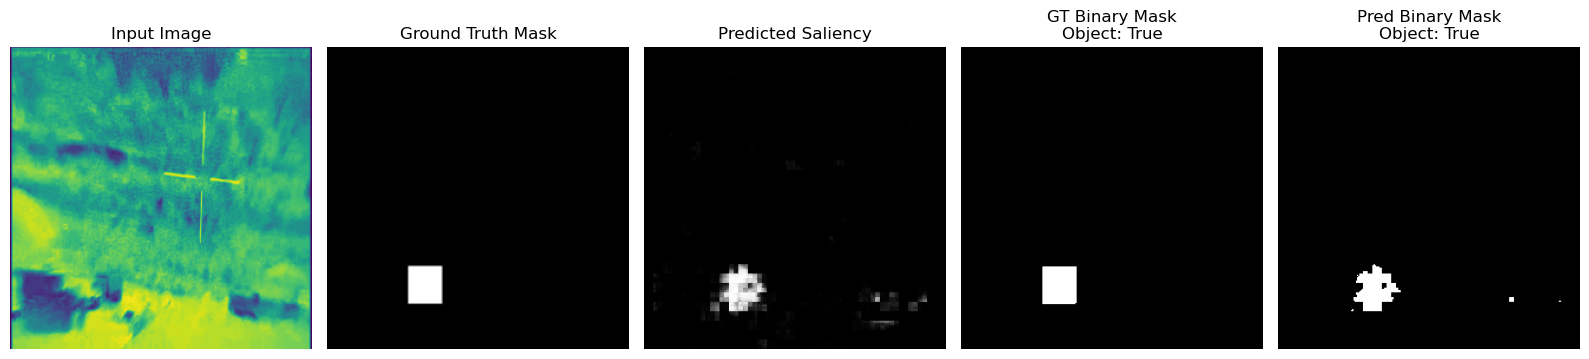

In [22]:
def visualize_detection_logic(model, dataloader, threshold=0.5, area_fraction=0.001, num_samples=10):
    model.eval()
    with torch.no_grad():
        # Randomly select indices
        indices = random.sample(range(len(dataloader.dataset)), num_samples)
        
        for idx in indices:
            # Get the image and its corresponding mask for the selected index
            image, mask = dataloader.dataset[idx]
            image = image.unsqueeze(0).to(device)  # Add batch dimension
            mask = mask.unsqueeze(0).to(device)    # Add batch dimension

            outputs = model(image)
            pred = outputs[0][0].cpu().numpy()  # Predicted saliency
            gt = mask[0][0].cpu().numpy()       # Ground truth saliency
            image = image[0].permute(1, 2, 0).cpu().numpy()

            # Thresholding
            pred_bin = pred > threshold
            gt_bin = gt > threshold

            # Object presence based on saliency area
            pred_present = (np.sum(pred_bin) / pred_bin.size) > area_fraction
            gt_present = (np.sum(gt_bin) / gt_bin.size) > area_fraction

            print(f"Predicted: {'Object Present' if pred_present else 'No Object'}")
            print(f"Ground Truth: {'Object Present' if gt_present else 'No Object'}")

            # Visualization
            fig, axs = plt.subplots(1, 5, figsize=(16, 4))
            axs[0].imshow(image)
            axs[0].set_title("Input Image")
            axs[1].imshow(gt, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred, cmap="gray")
            axs[2].set_title("Predicted Saliency")
            axs[3].imshow(gt_bin, cmap="gray")
            axs[3].set_title(f"GT Binary Mask\nObject: {gt_present}")
            axs[4].imshow(pred_bin, cmap="gray")
            axs[4].set_title(f"Pred Binary Mask\nObject: {pred_present}")

            for ax in axs:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

# Example usage
visualize_detection_logic(model, test_loader, threshold=0.5, area_fraction=0.001, num_samples=10)

# ------------------ Export Model to .PT ------------------

In [3]:
# Instantiate model and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.pth"))
model.eval()

/tmp/ipykernel_344183/2737398964.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/sal

Saliency_IR(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [4]:
model = model.to('cpu')

In [5]:
dummy_input = torch.randn(1, 1, 256, 256)
# Trace the model to TorchScript
scripted_model = torch.jit.trace(model, dummy_input)

In [6]:
# Save the TorchScript model
output_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.pt"
scripted_model.save(output_path)

print(f"TorchScript model saved to {output_path}")

TorchScript model saved to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_ir.pt
